In [1]:
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import deque
from sklearn.linear_model import LinearRegression

from game import play
from game import play_step
from utils import generate_board
from utils import boards_to_array
from players import trained_player

In [2]:
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 10_000
SOLVED_SCORE = 120
MAX_STEPS = 41
EPS = 0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(observation_space, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, action_space)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        
        return x

In [4]:
class StateValueNetwork(nn.Module):
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        self.layer1 = nn.Linear(observation_space, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        
        return x

In [5]:
policy_network = PolicyNetwork(90, 81).to(DEVICE)
stateval_network = StateValueNetwork(90).to(DEVICE)

policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)

In [6]:
scores = []
recent_scores = deque(maxlen = 100)

for episode in tqdm(range(NUM_EPISODES)):
    all_board, global_board = generate_board()
    state = boards_to_array(all_board, global_board)
    next_action_basis = (None, None)
    done = False
    score = 0
    I = 1
    
    for step in range(MAX_STEPS):
        action, lp = trained_player(all_board, global_board, next_action_basis, policy_network, eps=EPS, training=True)
        
        all_board, global_board, reward, next_action_basis = play_step(all_board, global_board, action, player = 0)
        new_state = boards_to_array(all_board, global_board)
        score += reward
        
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)
        
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = stateval_network(new_state_tensor)
        
        done = reward != 1
        if not done:
            all_board, global_board, other_reward, next_action_basis = play_step(all_board, global_board, next_action_basis, player = 1)
            new_state = boards_to_array(all_board, global_board)
            if other_reward == 100: reward = -50
            else: reward = other_reward
            score += reward
            done = reward != 1
        
        if done: new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I
        
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I
        
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()
        
        if done: break
        state = new_state
        I *= DISCOUNT_FACTOR
    
    scores.append(score)
    recent_scores.append(score)
    if np.array(recent_scores).mean() >= SOLVED_SCORE and len(recent_scores) == 100: break

100%|██████████| 10000/10000 [04:28<00:00, 37.26it/s]


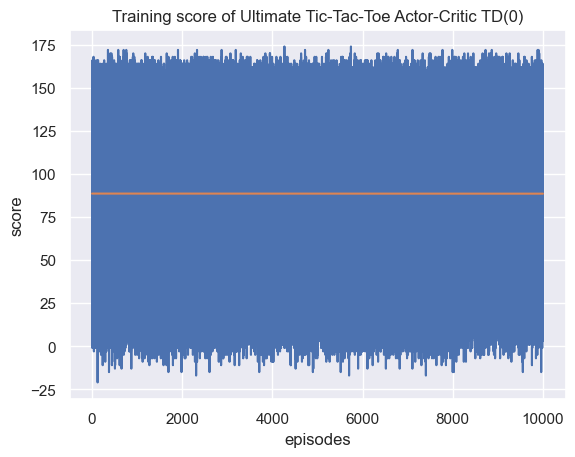

In [7]:
sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of Ultimate Tic-Tac-Toe Actor-Critic TD(0)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [8]:
def rl_player(all_board, global_board, i, j):
    next_action_basis = (i, j)
    return trained_player(all_board, global_board, next_action_basis, policy_network)

In [9]:
games = 10_000
result = ['X won', 'draw', 'O won']

In [10]:
results = [play(player_0=rl_player) for _ in tqdm(range(games))]
results, counts = np.unique(results, return_counts = True)
counts = counts / np.sum(counts)

p = list()
for r in result:
    inx = np.argmax(results == r)
    print(f'{r}: {counts[inx]:.2%}')
    p.append(counts[inx])

100%|██████████| 10000/10000 [01:22<00:00, 120.78it/s]

X won: 38.41%
draw: 22.36%
O won: 39.23%


In [11]:
results = [play() for _ in tqdm(range(games))]
results, counts = np.unique(results, return_counts = True)
counts = counts / np.sum(counts)

p = list()
for r in result:
    inx = np.argmax(results == r)
    print(f'{r}: {counts[inx]:.2%}')
    p.append(counts[inx])

100%|██████████| 10000/10000 [00:31<00:00, 315.48it/s]

X won: 41.46%
draw: 22.25%
O won: 36.29%


In [12]:
policy_network = torch.jit.load('policy_X.pt')
results = [play(player_0=rl_player) for _ in tqdm(range(games))]
results, counts = np.unique(results, return_counts = True)
counts = counts / np.sum(counts)

p = list()
for r in result:
    inx = np.argmax(results == r)
    print(f'{r}: {counts[inx]:.2%}')
    p.append(counts[inx])

100%|██████████| 10000/10000 [00:57<00:00, 172.65it/s]

X won: 71.50%
draw: 13.61%
O won: 14.89%


In [13]:
# model_scripted = torch.jit.script(policy_network)
# model_scripted.save('policy_X_2.pt')

# model_scripted = torch.jit.script(stateval_network)
# model_scripted.save('stateval_X_2.pt')